In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("../input/emails-sample/emails.csv")
data.head(data.shape[0])

,text,spam
0,dear friend im writing to you from hogwarts,0
1,dear dad lets have a lunch with my friend,0
2,dear mom ive got a new friend and new lunch bu...,0
3,dear sara with all my love your friend,0
4,dear brother my brother from another mother,0
5,dear friend ive nothing to say but im eating m...,0
6,dear a very normal message nothing wrong with ...,0
7,dear someone what do you know about kdlqlwkmwki,0
8,dear is a word used for greetings learn now on...,1
9,dear user earn money now,1


In [3]:
def clean(text):
    text = text.lower()
    text = text.replace(",", "").replace("'","").replace("?","")
    return text

# Add 1 to each word count (to avoid zeros in probabilities)
def add_alpha(dtm):
    words = dtm['word'].unique()
    classes = dtm['spam'].unique()
    for word in words:
        for _class in classes:
            row = dtm[(dtm['word'] == word) & (dtm['spam'] == _class)]
            word_index = -1 if row.index.shape[0] == 0 else row.index[0]
            if word_index != -1:
                dtm.iloc[word_index]['count'] += 1
            else:
                dtm = dtm.append(pd.Series({"word":word, "count":1, "spam":_class}), ignore_index=True)
    return dtm

In [4]:
# Clean data & get a copy of data separated

data['text'] = data['text'].apply(clean)

non_spam_text = data[data['spam'] == 0]['text']
spam_text = data[data['spam'] == 1]['text']

In [5]:
# Create count vectorizer for each class

# Ham count vectorizer
words, counts = np.unique(np.array(" ".join(non_spam_text.to_numpy()).split(" ")),return_counts=True)
dtm_non_spam = pd.DataFrame(data=(words,counts, np.zeros(len(words)))).T

# Spam count vectorizer
words, counts = np.unique(np.array(" ".join(spam_text.to_numpy()).split(" ")),return_counts=True)
dtm_spam = pd.DataFrame(data=(words,counts, np.ones(len(words)))).T

# Concatenate countvectorizer into document term matrix
dtm = pd.concat((dtm_non_spam, dtm_spam))
dtm.columns = ['word', 'count', 'spam']
dtm

,word,count,spam
0,a,3,0.0
1,about,1,0.0
2,all,1,0.0
3,and,1,0.0
4,another,1,0.0
...,...,...,...
22,used,1,1.0
23,user,1,1.0
24,with,1,1.0
25,word,1,1.0


In [6]:
# Add alpha (a number to increment counts to avoid zeros)
dtm = add_alpha(dtm)

# Initialize the example we're working on
# for words: dear, friend, lunch, money
example = dtm[dtm['word'].isin(['dear', 'friend', 'lunch', 'money'])].sort_values(by="word")
example

,word,count,spam
8,dear,9,0.0
47,dear,3,1.0
11,friend,6,0.0
52,friend,2,1.0
23,lunch,4,0.0
92,lunch,1,1.0
26,money,2,0.0
60,money,5,1.0


In [7]:
# Convert counts to probabilities (Term frequency)
def counts_to_proba(dtm):
    ham_words = dtm[dtm['spam'] == 0]
    spam_words = dtm[dtm['spam'] == 1]
    
    ham_words_count = ham_words['count'].sum()
    spam_words_count = spam_words['count'].sum()
    
    ham_words.rename(columns={"count":"probability"}, inplace=True)
    spam_words.rename(columns={"count":"probability"}, inplace=True)
    
    # Probability of a word = 
    # word count in a specific class / total counts of words of that class
    ham_words.loc[:,'probability'] = ham_words['probability'].apply(lambda count: count / ham_words_count)
    spam_words.loc[:,'probability'] = spam_words['probability'].apply(lambda count: count / spam_words_count)
    
    return pd.concat((ham_words, spam_words))

def naive_bayes(data, dtm, sentence):
    
    # Initialize prior probability
    total_messages_count = data.shape[0]
    ham_prior_proba = data[data['spam'] == 0].shape[0] / total_messages_count
    spam_prior_proba = data[data['spam'] == 1].shape[0] / total_messages_count
    
    # Convert counts to probabilities (term frequency)
    words_proba = counts_to_proba(dtm)
    
    # class probability is the production of 
    # class prior probability and probabilities of the words in a sentence
    ham_probability = ham_prior_proba
    spam_probability = spam_prior_proba
    
    # Multiply probabilities of each word in the sentence
    for word in sentence:
        # Get word and its probability 
        word_proba = words_proba[words_proba['word'] == word]
        
        # If word doesn't exist, ignore it
        if word_proba.shape[0] == 0:
            continue
            
        # Multiply production with word's probability for each class
        ham_probability *= word_proba[word_proba['spam'] == 0]['probability'].values[0]
        spam_probability *= word_proba[word_proba['spam'] == 1]['probability'].values[0]
    return np.array([ham_probability, spam_probability])

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


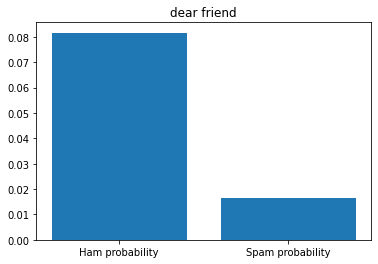

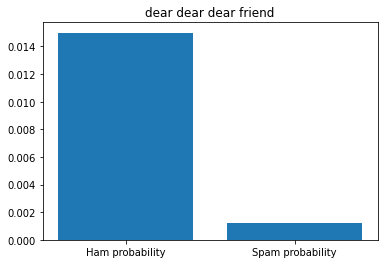

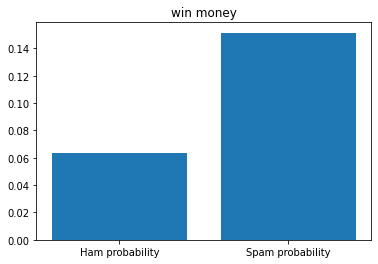

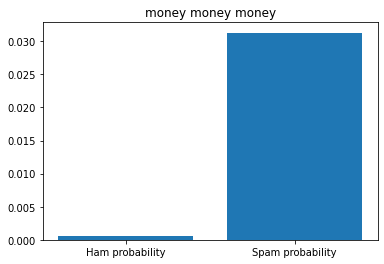

In [8]:
samples = np.array([
    "dear friend",
    "dear dear dear friend",
    "win money",
    "money money money",
])

for sample in samples:
    ham_proba, spam_proba = naive_bayes(data, example, sample.split(" "))
    plt.bar(["Ham probability", "Spam probability"], [ham_proba, spam_proba])
    plt.title(sample)
    plt.show()